# Solution for Portuguese banking institution by 2022/P/1123

### Install required packages

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix



#### Load data

In [101]:

df=pd.read_csv('banking.csv')

df.shape

(41188, 21)

#### Check the types of the data set

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp_var_rate    41188 non-null  float64
 16  cons_price_idx  41188 non-null  float64
 17  cons_conf_idx   41188 non-null 

#### Describing the data set


In [103]:
df.describe()


,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.112654
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528,0.316173
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


### check  for missing values

In [104]:

df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64

In [105]:
df.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1
5,30,management,divorced,basic.4y,no,yes,no,cellular,jul,tue,...,8,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,0
6,37,blue-collar,married,basic.4y,no,yes,no,cellular,may,thu,...,1,999,0,nonexistent,-1.8,92.893,-46.2,1.327,5099.1,0
7,39,blue-collar,divorced,basic.9y,no,yes,no,cellular,may,fri,...,1,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,0
8,36,admin.,married,university.degree,no,no,no,cellular,jun,mon,...,1,3,1,success,-2.9,92.963,-40.8,1.266,5076.2,1
9,27,blue-collar,single,basic.4y,no,yes,no,cellular,apr,thu,...,2,999,1,failure,-1.8,93.075,-47.1,1.410,5099.1,0


### Handling unkown values


In [106]:
unknown_counts = df.apply(lambda x: x[x == 'unknown'].count())
unknown_counts

age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp_var_rate         0
cons_price_idx       0
cons_conf_idx        0
euribor3m            0
nr_employed          0
y                    0
dtype: int64

As we see here there are some unkown values in columns job,marital,eduction,default,housing and loan .As the next step we gonna replace the unkown values with mode value of the each column

In [107]:
for column in ['job','marital','education','default','housing','loan']:
    mode_val = df[column].mode()[0]
    df[column] = df[column].replace('unknown',mode_val)
unknown_counts = df.apply(lambda x: x[x == 'unknown'].count())
unknown_counts
df.shape

(41188, 21)

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp_var_rate    41188 non-null  float64
 16  cons_price_idx  41188 non-null  float64
 17  cons_conf_idx   41188 non-null 

we drop duration to achive realistic predictive model . Including it would artificially inflate the model’s performance, making the evaluation results unreliable for real-world scenarios.

In [109]:
df=df.drop(columns=['duration'])

### Removing Outliers

In [110]:

int_float_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop(['y'])
for column in int_float_cols:
 
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)

  
    IQR = Q3 - Q1

 
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR


    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df.shape
  


(24919, 20)

## Q Q Plot and Histogram

In [ ]:
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns

for column in numerical_features:
    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    stats.probplot(df[column], dist="norm", plot=plt,)
    plt.title(f'Q-Q Plot of {column}')

    plt.subplot(1, 2, 2)
    sns.histplot(df[column], bins=30, color='green', kde=True)
    plt.title(f'Histogram of {column}')
    


plt.tight_layout()
plt.show()




Due to skeweness we need to get rid of them to make our distribution looks normal.I use log transformation for this.Log trnasformation mostly used in right skeweness

### Handle age skeweness

In [ ]:

log_age,_ = stats.boxcox(df['age'])
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(log_age, bins=30,color='green', edgecolor='k', alpha=0.7)
plt.title(f'Histogram of age')
plt.xlabel('age')
plt.ylabel('Frequency')


plt.subplot(1, 2, 2)
stats.probplot(log_age, dist="norm", plot=plt )
plt.title(f'Q-Q Plot of age')

plt.tight_layout()
plt.show()




### One hot encoding and label encoding


In [113]:
df['month'] = LabelEncoder().fit_transform(df['month'])
df['day_of_week'] = LabelEncoder().fit_transform(df['day_of_week'])
df['education'] = LabelEncoder().fit_transform(df['education'])
df['job'] = LabelEncoder().fit_transform(df['job'])
df = pd.get_dummies(df, columns=['marital','contact','default','housing','loan','poutcome'], drop_first=True)
df.head(10)

,age,job,education,month,day_of_week,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y,marital_married,marital_single,contact_telephone,default_yes,housing_yes,loan_yes
0,44,1,0,0,2,1,999,0,1.4,93.444,-36.1,4.963,5228.1,0,True,False,False,False,True,False
1,53,9,6,5,0,1,999,0,-0.1,93.200,-42.0,4.021,5195.8,0,True,False,False,False,False,False
10,34,3,6,4,0,2,999,0,1.1,93.994,-36.4,4.864,5191.0,0,False,True,True,False,False,False
11,41,4,6,0,2,1,999,0,1.4,93.444,-36.1,4.964,5228.1,0,True,False,False,False,True,False
12,55,4,6,0,1,3,999,0,1.4,93.444,-36.1,4.965,5228.1,1,True,False,False,False,False,False
14,26,0,3,3,1,1,999,0,1.4,94.465,-41.8,4.960,5228.1,0,True,False,True,False,False,True
15,52,7,3,2,2,2,999,0,1.4,93.918,-42.7,4.962,5228.1,0,True,False,False,False,True,False
17,27,0,6,6,3,1,999,0,-0.1,93.798,-40.4,4.860,5195.8,1,False,True,True,False,False,False
18,28,1,2,4,2,1,999,0,1.1,93.994,-36.4,4.860,5191.0,0,True,False,True,False,False,False
19,26,10,2,2,1,4,999,0,1.4,93.918,-42.7,4.960,5228.1,0,False,True,False,False,True,True


### Standardize other columns

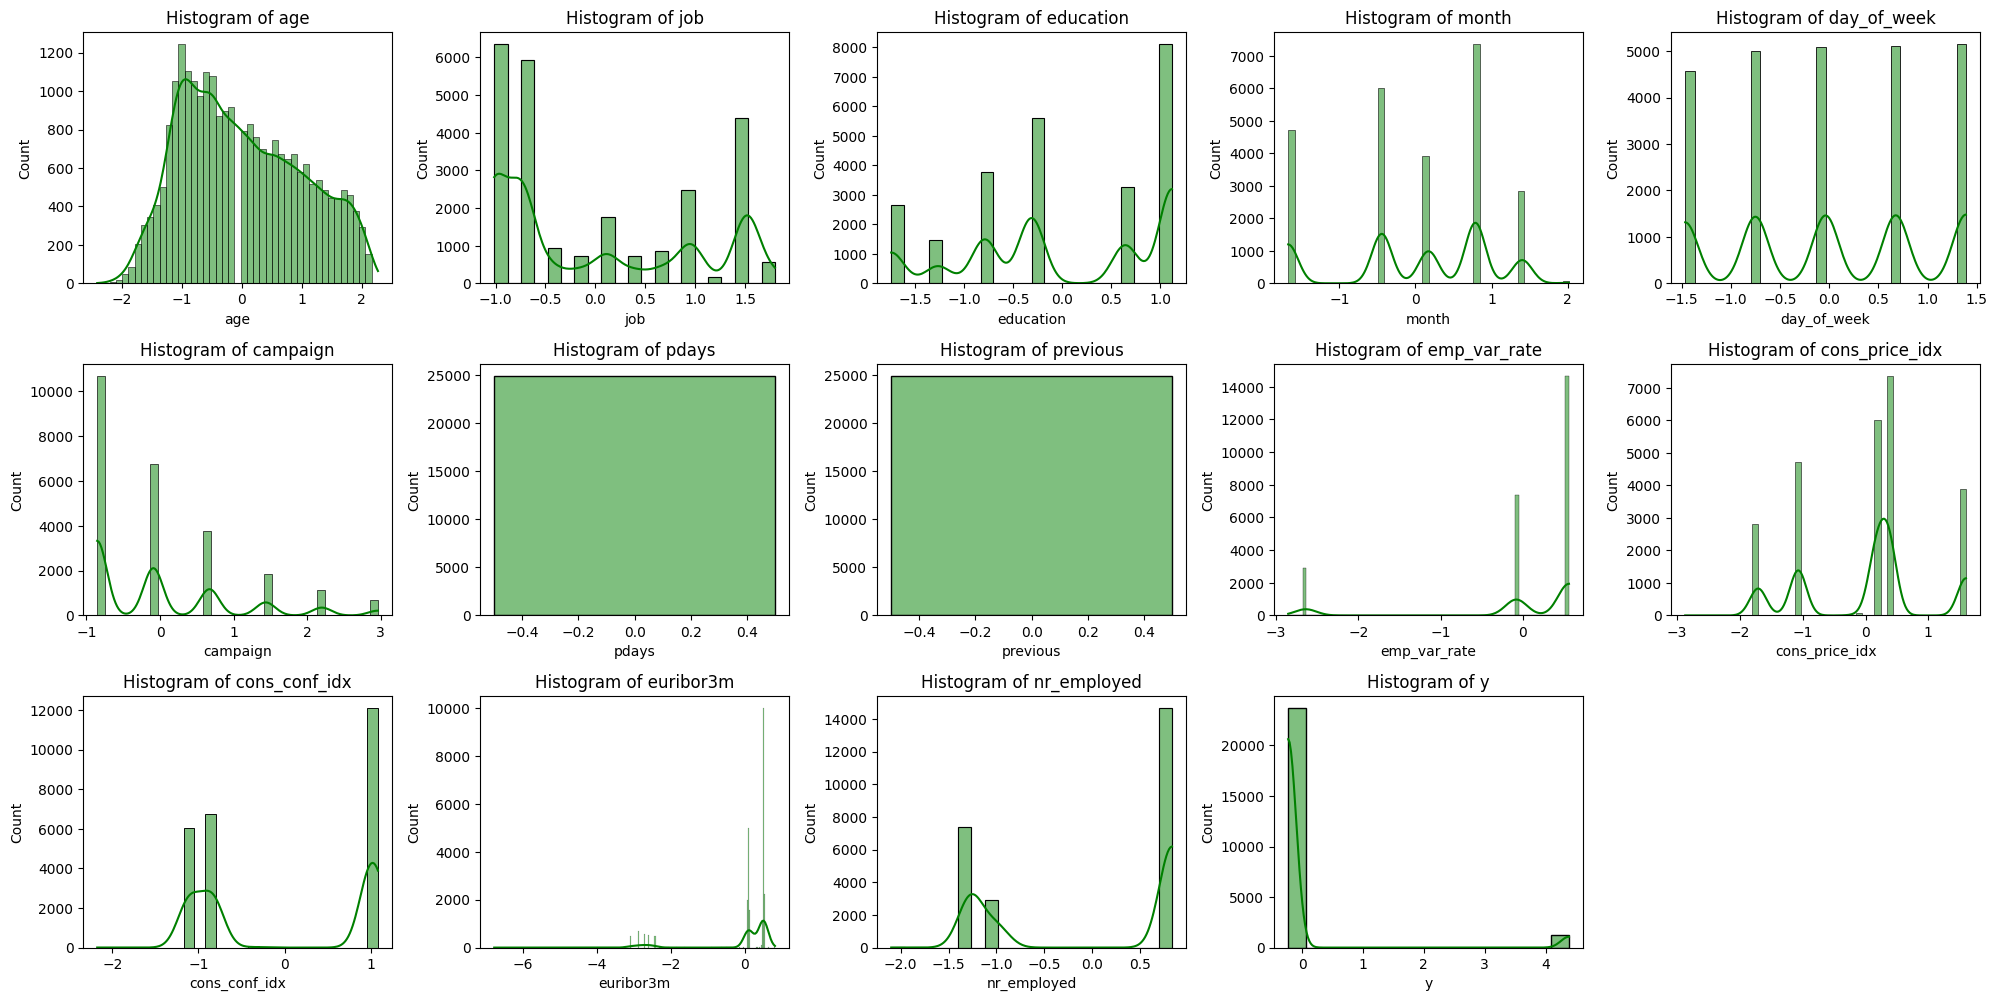

In [114]:


from sklearn.discriminant_analysis import StandardScaler


numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])


plt.figure(figsize=(20, 13))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(4, 5, i)
    sns.histplot(df[column], kde=True, color='green', label='Skewness: {:.2f}'.format(df[column].skew()))
    plt.title(f'Histogram of {column}')

plt.tight_layout()
plt.show()


In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24919 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                24919 non-null  float64
 1   job                24919 non-null  float64
 2   education          24919 non-null  float64
 3   month              24919 non-null  float64
 4   day_of_week        24919 non-null  float64
 5   campaign           24919 non-null  float64
 6   pdays              24919 non-null  float64
 7   previous           24919 non-null  float64
 8   emp_var_rate       24919 non-null  float64
 9   cons_price_idx     24919 non-null  float64
 10  cons_conf_idx      24919 non-null  float64
 11  euribor3m          24919 non-null  float64
 12  nr_employed        24919 non-null  float64
 13  y                  24919 non-null  float64
 14  marital_married    24919 non-null  bool   
 15  marital_single     24919 non-null  bool   
 16  contact_telephone  24919 no

## Descretize

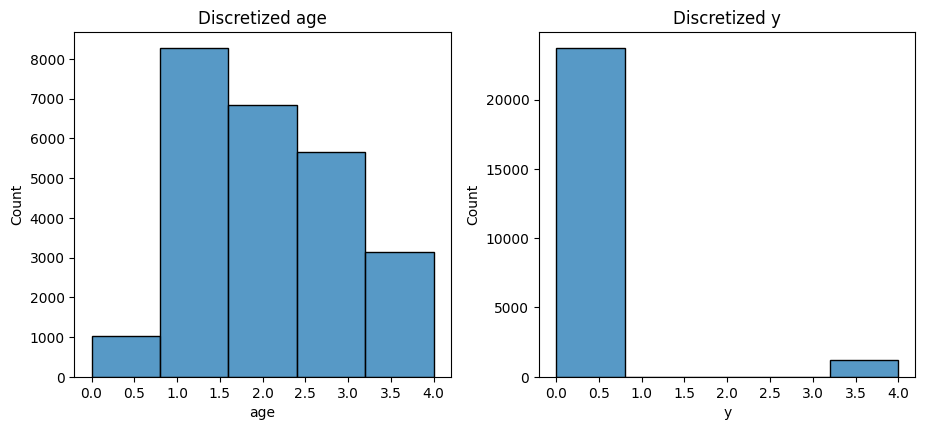

In [116]:
# Discretize features
from sklearn.preprocessing import KBinsDiscretizer


features_to_discretize = ['age','y']
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')

df[features_to_discretize] = discretizer.fit_transform(df[features_to_discretize])

# Visualize the effect of discretization
plt.figure(figsize=(14, 8))
for i, column in enumerate(features_to_discretize, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[column], kde=False, bins=5)
    plt.title(f'Discretized {column}')

plt.tight_layout()
plt.show()

# Correlation

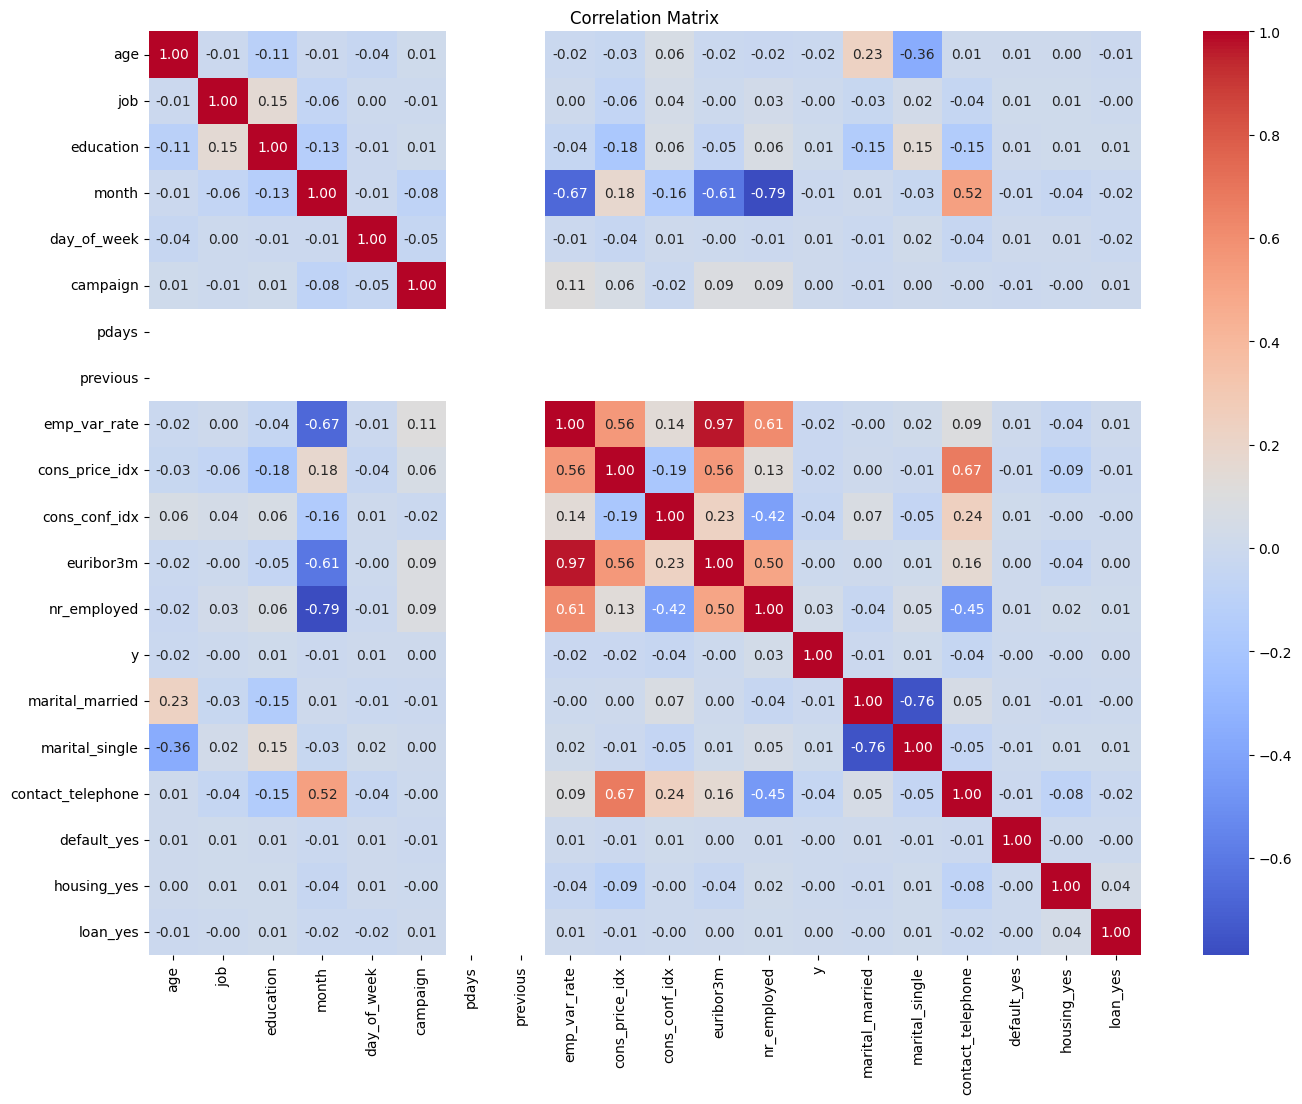

In [117]:
correlation_matrix = df.corr()
# Plot the correlation matrix using a heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()
correlations_with_y = correlation_matrix['y'].sort_values(ascending=False)




### Perform PCA


In [118]:
X = df.drop(columns=['y'])
y = df['y']
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)





# Optional: DataFrame with principal components

In [119]:

df_pca = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(principal_components.shape[1])])
df_pca.head()

,PC1,PC2
0,1.308917,-0.604869
1,-4.548152,-1.716069
2,-0.746328,0.612616
3,1.333908,-2.046411
4,1.441582,-1.749694


In [120]:
# Explained variance
print("Explained variance by each component:", pca.explained_variance_ratio_)


Explained variance by each component: [0.26491811 0.13558142]


### Plotting the principal components


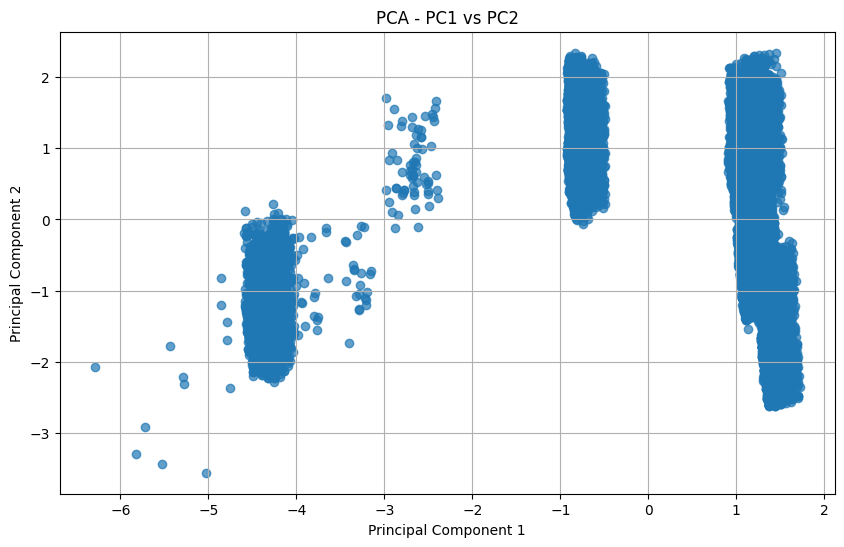

In [121]:
plt.figure(figsize=(10, 6))
plt.scatter(df_pca['PC1'], df_pca['PC2'], alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA - PC1 vs PC2')
plt.grid(True)
plt.show()

### Train-Test Splitting

In [122]:
X_train, X_test, y_train, y_test = train_test_split(principal_components, y, test_size=0.2, random_state=4)


### Train SVM and Logistic Regression Models

#### SVM

In [123]:
# print("Training set class distribution:\n", pd.Series(y_train).value_counts())
# print("Test set class distribution:\n", pd.Series(y_test).value_counts())

print(y_train[y_train > 0].count())


955


In [124]:

svm_model = SVC(class_weight='balanced',C= 100, gamma= np.float64(0.7262660638759781), kernel='linear')

svm_model.fit(X_train, y_train)

SVC(C=100, class_weight='balanced', gamma=np.float64(0.7262660638759781),
    kernel='linear')

## SVM Evaluation


In [125]:
y_pred_svm = svm_model.predict(X_test)
cm_svm = confusion_matrix(y_test, y_pred_svm)
desicion_score_svm = svm_model.decision_function(X_test)
desicion_score_svm


array([ 0.22887049,  0.81602782, -0.5656184 , ..., -0.8348823 ,
        0.94216696,  0.42950991])

In [126]:
# from sklearn.model_selection import GridSearchCV


# param_grid = {
#     'C': [0.1, 1],
#     'gamma': [1, 0.1, ],
#     'kernel': [ 'linear']
# }

# grid_search = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, cv=5)
# bp=grid_search.fit(X_train, y_train)
# print(grid_search.best_params_)

#### LR

In [127]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

LogisticRegression()

# Logistic Regression Evaluation

In [128]:
y_pred_lr = lr_model.predict(X_test)
cm_lr = confusion_matrix(y_test, y_pred_lr)

# Convert confusion matrix to DataFrame for better visualization

In [129]:
df_cm_svm = pd.DataFrame(cm_svm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
df_cm_lr = pd.DataFrame(cm_lr, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])

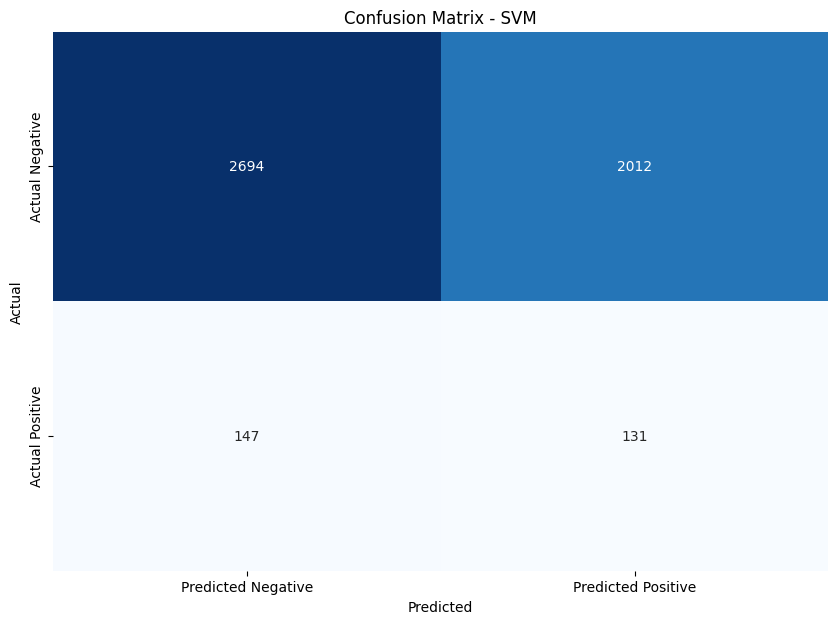

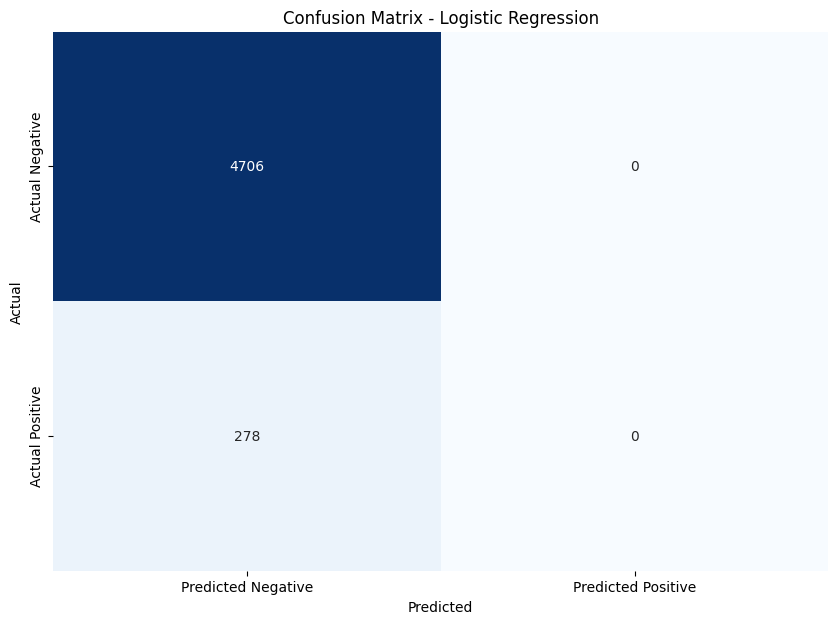

In [130]:
# Plot confusion matrix for SVM
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm_svm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot confusion matrix for Logistic Regression
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm_lr, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [131]:
print(classification_report(y_test,y_pred_svm))

              precision    recall  f1-score   support

         0.0       0.95      0.57      0.71      4706
         4.0       0.06      0.47      0.11       278

    accuracy                           0.57      4984
   macro avg       0.50      0.52      0.41      4984
weighted avg       0.90      0.57      0.68      4984



### Model Evaluation Metrics

#### SVM

- **Accuracy:** `accuracy_score(y_test, y_pred_svm)`
- **Classification Report:**



#### Logistic Regression

- **Accuracy:** `accuracy_score(y_test, y_pred_lr)`
- **Classification Report:**



### Summary Table

| Metric                    | SVM                  | Logistic Regression |
|---------------------------|----------------------|---------------------|
| **Accuracy**              | `accuracy_score(y_test, y_pred_svm)` | `accuracy_score(y_test, y_pred_lr)` |
| **Classification Report** | `classification_report(y_test, y_pred_svm)` | `classification_report(y_test, y_pred_lr)` |
| **Confusion Matrix**      | `confusion_matrix(y_test, y_pred_svm)` | `confusion_matrix(y_test, y_pred_lr)` |
